In [1]:
%run ../../code/imports.ipynb
from contextlib import contextmanager
from sqlalchemy import create_engine, inspect, text
from sqlalchemy.orm import sessionmaker
import urllib
import duckdb

from src.compustat import CompustatAnnual, CompustatAnnualRDQ
from src.crsp import CRSP

Set LOG_LEVEL="INFO" before running the import file to get moar output.
Set LOG_FORMAT to change log format.
Numpy (np): 2.3.5
Scipy (sp, stats): 1.16.3
Pandas (pd): 2.3.3
MatPlotLib (mpl, plt): 3.10.7
Seaborn (sns): 0.13.2
Scikit-Learn (sk): 1.7.2
Statsmodels (sm): 0.14.6
Patsy (pt): 1.0.2
SQLAlchemy (sa): 2.0.44
ROOT_DIR: 5150_Analytics
CODE_DIR: 5150_Analytics\code
DATA_DIR: 5150_Analytics\data
FIG_DIR: 5150_Analytics\labs_hw\week5_RDB\figures


In [2]:
def fill_last_year(x):
    try:
        return dt.datetime(x.year - 1, x.month, x.day - (x.is_leap_year * (x.month == 2) * (x.day == 29)))
    except Exception as e:
        print(f"Error {e}: {x}")
        return pd.NaT
def fill_next_year(x):
    try:
        return dt.datetime(x.year + 1, x.month, x.day - (x.is_leap_year * (x.month == 2) * (x.day == 29)))
    except Exception as e:
        print(f"Error {e}: {x}")
        return pd.NaT
def add_bins(df, col, nbins=5, labels=None):
    if labels is None:
        labels = [f'Bin {i}' for i in range(1, nbins+1)]
    return (
        df
        .assign(**{f'{col}_bins': lambda df,col=col,nbins=nbins,labels=labels:
                                   df.groupby(S('fyear'))[col].transform(lambda x: pd.qcut(x, q=nbins, labels=labels))})
    )

In [40]:
KEEP_TICS = ['AAL', 'AAPL', 'AMD', 'BAC', 'C', 'COST', 'CVX', 'DAL', 'F', 'GM', 'GOOG', 'GOOGL', 'INTC', 'JPM', 'KO', 'LULU', 'MSFT', 'NKE', 'NVDA', 'PG', 'TGT', 'SHEL', 'UAL', 'WMT', 'XOM']
len(KEEP_TICS)

25

In [4]:
dfraw = CompustatAnnualRDQ().data.query("rdq.notnull()").drop_duplicates()
df = dfraw.merge(dfraw['gvkey fyear datadate rdq'.split()].assign(fyear=lambda df: df.fyear + 1), on=['gvkey', 'fyear'], how='left', suffixes=('', '_prev')).drop_duplicates()
df = df.merge(dfraw['gvkey fyear datadate rdq'.split()].assign(fyear=lambda df: df.fyear - 1), on=['gvkey', 'fyear'], how='left', suffixes=('', '_next')).drop_duplicates()
DT_RENAME = {'datadate': 'fiscal_year_end', 'rdq':'earn_annc_date'}
for c in list(DT_RENAME.keys()):
    df[c + '_prev'] = df[c + '_prev'].fillna(df[c].apply(fill_last_year))
    df[c + '_next'] = df[c + '_next'].fillna(df[c].apply(fill_next_year))
    DT_RENAME[c + '_prev'] = DT_RENAME[c] + '_prev'
    DT_RENAME[c + '_next'] = DT_RENAME[c] + '_next'
df = df[df.tic.isin(KEEP_TICS) & (df.fyear >= 2000)].sort_values(['tic', 'permno', 'fyear']).reset_index(drop=True)

display(df[df.S('gvkey da* rd* *')].head(3))
df.describe(include='all')

,gvkey,datadate,datacqtr,datafqtr,datadate_prev,datadate_next,rdq,rdq_prev,rdq_next,tic,name,fyear,fyr,age_days,permno,permco,at,act,lt,lct,invt,ap,rect,recd,total_debt,che,re,oancf,ebit,ebitda,ni,ib,pi,sale,revt,eps,eps_noex,xad,xrd,xsga,xint,capx,cogs,dvt,accruals,emp,share_price,shares_outstanding,mve,seq,bve,bign,auditor,auop,auopic,gics_group,gics_industry,gics_sector,gics_subindustry,gics_sector_name,gics_group_name,gics_industry_name,gics_subindustry_name
0,1045,2000-12-31,2000Q4,2000Q4,1999-12-31,2001-12-31,2001-01-17,2000-01-19,2002-01-16,AAL,AMERICAN AIRLINES GROUP INC,2000,12,18263,"21,020","20,010","26,213","5,179","19,037","6,990",757,"1,267","1,303",27,"6,270","2,233","5,948","3,142","1,381","2,583",813,779,"1,287","19,703","19,703",5.430,5.200,221,NaN,NaN,467,"3,678","17,120",0,"-2,363",NaN,39.188,152.063,"5,959","7,176","7,176",1,Ernst & Young,Unqualified,NaN,"2,030","203,020",20,"20,302,010",Industrials,Transportation,Passenger Airlines,Passenger Airlines
1,1045,2001-12-31,2001Q4,2001Q4,2000-12-31,2002-12-31,2002-01-16,2001-01-17,2003-01-22,AAL,AMERICAN AIRLINES GROUP INC,2001,12,18628,"21,020","20,010","32,841","6,540","27,468","7,512",822,"1,785","1,414",52,"10,606","2,992","4,042",511,"-1,860",-456,"-1,762","-1,762","-2,756","18,963","18,963",-11.430,-11.430,202,NaN,NaN,538,"3,640","19,419",0,"-2,273",NaN,22.300,154.485,"3,445","5,373","5,373",1,Ernst & Young,Unqualified with additional language,NaN,"2,030","203,020",20,"20,302,010",Industrials,Transportation,Passenger Airlines,Passenger Airlines
2,1045,2002-12-31,2002Q4,2002Q4,2001-12-31,2003-12-31,2003-01-22,2002-01-16,2004-01-21,AAL,AMERICAN AIRLINES GROUP INC,2002,12,18993,"21,020","20,010","30,267","4,937","29,310","7,240",627,"1,198","1,481",66,"13,178","2,733",-399,"-1,111","-2,622","-1,256","-3,511","-2,523","-3,860","17,299","17,299",-22.570,-16.220,161,NaN,NaN,685,"1,881","18,555",0,"-1,412",109.600,6.600,156.089,"1,030",957,957,1,Ernst & Young,Unqualified with additional language,NaN,"2,030","203,020",20,"20,302,010",Industrials,Transportation,Passenger Airlines,Passenger Airlines


,gvkey,tic,name,fyear,fyr,rdq,age_days,datadate,datacqtr,datafqtr,permno,permco,at,act,lt,lct,invt,ap,rect,recd,total_debt,che,re,oancf,ebit,ebitda,ni,ib,pi,sale,revt,eps,eps_noex,xad,xrd,xsga,xint,capx,cogs,dvt,accruals,emp,share_price,shares_outstanding,mve,seq,bve,bign,auditor,auop,auopic,gics_group,gics_industry,gics_sector,gics_subindustry,gics_sector_name,gics_group_name,gics_industry_name,gics_subindustry_name,datadate_prev,rdq_prev,datadate_next,rdq_next
count,604,604,604,604,604,604,604,604,604,604,597,597,604,500,604,500,595,604,604,363,604,604,602,594,604,604,604,604,604,604,604,604,604,452,382,564,530,592,604,601,592,600,604,604,604,604,604,604,604,590,511,604,604,604,604,604,604,596,553,604,604,604,604
unique,NaN,24,24,NaN,NaN,NaN,NaN,NaN,78,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,NaN,NaN,NaN,NaN,NaN,7,14,16,17,NaN,NaN,NaN,NaN
top,NaN,GOOGL,ALPHABET INC,NaN,NaN,NaN,NaN,NaN,2014Q4,2024Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ernst & Young,Unqualified,NaN,NaN,NaN,NaN,NaN,Information Technology,Transportation,Passenger Airlines,Passenger Airlines,NaN,NaN,NaN,NaN
freq,NaN,32,32,NaN,NaN,NaN,NaN,NaN,20,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,239,369,NaN,NaN,NaN,NaN,NaN,146,77,77,77,NaN,NaN,NaN,NaN
mean,"24,679",NaN,NaN,"2,013",9.199,2013-08-10 20:15:53.642384128,"16,263",2013-07-15 16:00:47.682119168,NaN,NaN,"48,433","19,397","372,059","40,842","303,645","29,912","18,114","147,065","110,735","1,509","92,405","66,806","56,000","17,698","17,536","22,911","11,532","11,502","15,568","114,751","114,751",4.595,4.602,"2,275","5,307","18,635","2,133","7,158","74,439","3,654","-6,185",205.037,116.603,"2,825","236,560","67,661","67,661",0.977,NaN,NaN,1.008,"3,096","309,639",30.762,"30,963,902",NaN,NaN,NaN,NaN,2012-07-15 02:08:44.503311360,2012-08-10 02:54:02.384105984,2014-07-15 21:44:06.357615872,2014-08-11 05:21:51.258278144
min,"1,045",NaN,NaN,"2,000",1,2000-07-18 00:00:00,"1,492",2000-06-30 00:00:00,NaN,NaN,"10,107",7,155.092,97.906,42.739,35.822,0,1.045,4.029,0,0,53.339,"-102,926","-110,560","-28,387","-9,022","-38,732","-43,297","-53,055",274.713,274.713,-182.290,-182.290,6.800,0,96.177,0,0,"-3,703",-709,"-128,237",0.796,0.350,52.539,109.829,"-86,154","-86,154",0,NaN,NaN,0,"1,010","101,020",10,"10,102,010",NaN,NaN,NaN,NaN,1999-06-30 00:00:00,1999-07-19 00:00:00,2001-06-30 00:00:00,2001-07-19 00:00:00
25%,"3,144",NaN,NaN,"2,006",6,2007-05-31 00:00:00,"10,957",2007-05-01 00:00:00,NaN,NaN,"14,593","7,882","32,978","8,266","20,720","7,271",972.740,"1,912","1,662",26.500,"5,237","3,944","2,300","2,080","2,402","4,168","1,239","1,251","1,713","30,893","30,893",1.407,1.435,344.750,436.500,"5,198",162.250,872.750,"13,902",0,"-11,472",62.225,30.520,556.865,"27,867","8,650","8,650",1,NaN,NaN,1,"2,510","251,020",25,"25,102,010",NaN,NaN,NaN,NaN,2006-05-01 00:00:00,2006-05-26 12:00:00,2008-04-30 18:00:00,2008-05-26 00:00:00
50%,"5,073",NaN,NaN,"2,013",12,2014-01-15 12:00:00,"17,167",2013-12-31 00:00:00,NaN,NaN,"55,976","20,468","94,076","21,908","60,606","17,150","4,400","6,608","5,590",69,"17,450","11,144","19,557","9,608","9,578","14,181","5,930","5,930","7,494","72,960","72,960",3.145,3.215,"1,700","1,505","12,556",681,"3,190","31,534","1,655","-3,607",99.450,53.800,"1,871","122,434","35,881","35,881",1,NaN,NaN,1,"3,010","301,010",30,"30,101,040",NaN,NaN,NaN,NaN,2012-12-31 00:00:00,2013-01-16 12:00:00,2014-12-31 00:00:00,2015-01-15 00:00:00
75%,"11,259",NaN,NaN,"2,019",12,2020-01-16 12:00:00,"21,915",2019-12-31 00:00:00,NaN,NaN,"70,519","21,446","277,046","57,696","171,538","38,240","10,781","25,957","35,541",537,"60,416","36,744","78,490","25,076","24,759","33,602","15,336","15,168","21,638"

In [5]:
dfcrsp = CRSP().data.query('date.dt.year >= 1999 and permno.isin(@df.permno.unique())').assign(shrcls=lambda df: df.shrcls.fillna('A'))
dfcrsp.describe(include='all')

C:\Users\gaulinmp\Dropbox\Documents\Programming\Python\reslib\reslib\data\cache.py:318: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return self.read_func(self.path, **kwargs)


,permno,ticker,shrcls,date,prc,vol,ret,bid,ask,shrout
count,"152,986",152502,152986,152986,"152,502","152,498","152,493","151,942","151,942","152,986"
unique,NaN,32,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,MSFT,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6541,143740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,"47,841",NaN,NaN,2012-07-06 09:26:52.524021760,112.555,"21,489,228",0.001,112.762,112.851,"2,521,010"
min,"10,107",NaN,NaN,1999-01-04 00:00:00,0.240,"41,250",-0.840,0.262,0.265,"28,596"
25%,"14,593",NaN,NaN,2006-04-19 00:00:00,31.900,"4,117,435",-0.010,31.810,31.860,"442,741"
50%,"49,154",NaN,NaN,2012-10-10 00:00:00,54,"9,296,394",0,54.010,54.120,"1,409,442"
75%,"70,519",NaN,NaN,2018-11-30 00:00:00,87.530,"21,763,360",0.011,87.620,87.780,"3,906,188"
max,"92,203",NaN,NaN,2024-12-31 00:00:00,"3,014","1,897,900,032",0.685,"3,014","3,015","29,206,400"


In [6]:
df_wt = (
    duckdb.query(f"""
    SELECT DISTINCT b.ticker, b.shrcls, a.*, b.date
    FROM df AS a
    INNER JOIN dfcrsp AS b
        ON a.permno = b.permno AND b.date BETWEEN a.datadate - INTERVAL 5 DAY AND a.datadate
    """)
    .to_df()
    .assign(mxd=lambda df: df.groupby(S("gvkey datadate permno ticker")).date.transform('max')==df.date)
    .query("mxd")
    .drop(columns=['date', 'mxd'])
    .sort_values('gvkey datadate ticker'.split())
    .rename(columns=DT_RENAME)
    .reset_index(drop=True)
)
df_wt = (
    df_wt
    .drop(columns=['gics_sector', 'gics_sector_name'])
    .merge(df_wt.groupby('name').gics_sector.value_counts().reset_index().groupby('name').head(1).drop(columns='count'), on='name', how='left')
    .merge(df_wt.groupby('name').gics_sector_name.value_counts().reset_index().groupby('name').head(1).drop(columns='count'), on='name', how='left')
)
# df_wt = (
#     df_wt
#     [[c for c in df_wt.S("firm_id name fyear datadate* rdq* age_days ticker shrcls *") if c not in ('tic', 'gvkey', 'fyr', 'datacqtr', 'datafqtr', 'permno', 'permco', 'auopic')]]
#
# )

display(df_wt.head(1))
df_wt.describe(include='all')

,ticker,shrcls,gvkey,tic,name,fyear,fyr,earn_annc_date,age_days,fiscal_year_end,datacqtr,datafqtr,permno,permco,at,act,lt,lct,invt,ap,rect,recd,total_debt,che,re,oancf,ebit,ebitda,ni,ib,pi,sale,revt,eps,eps_noex,xad,xrd,xsga,xint,capx,cogs,dvt,accruals,emp,share_price,shares_outstanding,mve,seq,bve,bign,auditor,auop,auopic,gics_group,gics_industry,gics_subindustry,gics_group_name,gics_industry_name,gics_subindustry_name,fiscal_year_end_prev,earn_annc_date_prev,fiscal_year_end_next,earn_annc_date_next,gics_sector,gics_sector_name
0,AMR,A,1045,AAL,AMERICAN AIRLINES GROUP INC,2000,12,2001-01-17,18263,2000-12-31,2000Q4,2000Q4,"21,020","20,010","26,213","5,179","19,037","6,990",757,"1,267","1,303",27,"6,270","2,233","5,948","3,142","1,381","2,583",813,779,"1,287","19,703","19,703",5.430,5.200,221,NaN,NaN,467,"3,678","17,120",0,"-2,363",NaN,39.188,152.063,"5,959","7,176","7,176",1,Ernst & Young,Unqualified,NaN,"2,030","203,020","20,302,010",Transportation,Passenger Airlines,Passenger Airlines,1999-12-31,2000-01-19,2001-12-31,2002-01-16,20,Industrials


,ticker,shrcls,gvkey,tic,name,fyear,fyr,earn_annc_date,age_days,fiscal_year_end,datacqtr,datafqtr,permno,permco,at,act,lt,lct,invt,ap,rect,recd,total_debt,che,re,oancf,ebit,ebitda,ni,ib,pi,sale,revt,eps,eps_noex,xad,xrd,xsga,xint,capx,cogs,dvt,accruals,emp,share_price,shares_outstanding,mve,seq,bve,bign,auditor,auop,auopic,gics_group,gics_industry,gics_subindustry,gics_group_name,gics_industry_name,gics_subindustry_name,fiscal_year_end_prev,earn_annc_date_prev,fiscal_year_end_next,earn_annc_date_next,gics_sector,gics_sector_name
count,583,583,583,583,583,583,583,583,583,583,583,583,583,583,583,481,583,481,574,583,583,353,583,583,583,575,583,583,583,583,583,583,583,583,583,436,373,546,513,573,583,583,575,579,583,583,583,583,583,583,583,573,495,583,583,583,583,575,532,583,583,583,583,583,583
unique,30,3,NaN,24,24,NaN,NaN,NaN,NaN,NaN,75,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,NaN,NaN,NaN,NaN,14,16,17,NaN,NaN,NaN,NaN,NaN,6
top,AAPL,A,NaN,GOOGL,ALPHABET INC,NaN,NaN,NaN,NaN,NaN,2017Q4,2022Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ernst & Young,Unqualified,NaN,NaN,NaN,NaN,Energy,"Oil, Gas & Consumable Fuels",Integrated Oil & Gas,NaN,NaN,NaN,NaN,NaN,Information Technology
freq,25,548,NaN,32,32,NaN,NaN,NaN,NaN,NaN,20,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233,359,NaN,NaN,NaN,NaN,70,70,70,NaN,NaN,NaN,NaN,NaN,156
mean,NaN,NaN,"24,800",NaN,NaN,"2,012",9.218,2013-05-24 11:29:07.512864512,"16,138",2013-04-28 10:54:32.727272704,NaN,NaN,"48,188","19,485","368,101","40,814","299,787","29,630","18,511","144,067","109,801","1,547","92,015","66,491","55,874","17,576","17,176","22,588","11,086","11,055","15,107","113,928","113,928",4.612,4.619,"2,276","5,162","18,271","2,162","7,130","74,228","3,627","-6,400",203.925,115.163,"2,795","221,561","67,569","67,569",0.983,NaN,NaN,1.006,"3,101","310,164","31,016,397",NaN,NaN,NaN,2012-04-27 20:47:20.480274432,2012-05-23 18:46:18.730703360,2014-04-28 16:47:45.180102912,2014-05-24 23:10:36.020583424,30.738,NaN
min,NaN,NaN,"1,045",NaN,NaN,"2,000",1,2000-07-18 00:00:00,"1,492",2000-06-30 00:00:00,NaN,NaN,"10,107",7,155.092,97.906,42.739,35.822,0,1.045,4.029,0,0,53.339,"-102,926","-110,560","-28,387","-9,022","-38,732","-43,297","-53,055",274.713,274.713,-68.450,-76.520,6.800,0,96.177,0,0,"-3,703",-709,"-128,237",0.796,0.350,52.539,117.344,"-86,154","-86,154",0,NaN,NaN,0,"1,010","101,020","10,102,010",NaN,NaN,NaN,1999-06-30 00:00:00,1999-07-19 00:00:00,2001-06-30 00:00:00,2001-07-19 00:00:00,10,NaN
25%,NaN,NaN,"3,144",NaN,NaN,"2,006",6,2007-05-05 00:00:00,"10,592",2007-04-01 00:00:00,NaN,NaN,"14,593","7,882","33,302","8,441","19,426","7,281",983.500,"1,930","1,694",27,"5,234","3,967","2,612","2,116","2,454","4,224","1,273","1,287","1,783","31,806","31,806",1.410,1.450,410.625,441,"5,221",158,880,"13,712",0,"-11,496",62.400,30.625,565.325,"28,454","8,750","8,750",1,NaN,NaN,1,"2,510","251,020","25,102,010",NaN,NaN,NaN,2006-04-01 00:00:00,2006-04-25 00:00:00,2008-03-31 12:00:00,2008-04-26 00:00:00,25,NaN
50%,NaN,NaN,"5,073",NaN,NaN,"2,013",12,2013-10-09 00:00:00,"16,802",2013-08-31 00:00:00,NaN,NaN,"55,976","20,468","94,685","21,910","61,408","16,877","4,412","6,625","5,624",73.600,"17,483","11,175","20,533","9,844","9,664","14,631","6,008","6,008","7,686","73,301","73,301",3.130,3.210,"1,702","1,453","12,370",683,"3,182","31,445","1,685","-3,626",99,53.610,"1,882","123,908","36,180","36,180",1,NaN,NaN,1,"3,010","301,010","30,101,040",NaN,NaN,NaN,2012-08-31 00:00:00,2012-10-10 00:00:00,2014-08-31 00:00:00,2014-10-08 00:00:00,30,NaN
75%,NaN,NaN,"11,259",NaN,NaN,"2,018",12,2019-05-12 00:00:00,"21,915",2019-04-01 00:00:00,NaN,NaN,"70,519","21,446","278,909","57,653","173,512

In [122]:
# dfraw[dfraw.gics_sector_name == 'Energy'].sort_values('mve', ascending=False)[['name', 'tic', 'fyear', 'mve']].head(50)

In [7]:
pd.crosstab(df_wt.name, df_wt.gics_sector_name)

gics_sector_name,Consumer Discretionary,Consumer Staples,Energy,Financials,Industrials,Information Technology
name,,,,,,
ADVANCED MICRO DEVICES,0,0,0,0,0,25
ALPHABET INC,0,0,0,0,0,32
AMERICAN AIRLINES GROUP INC,0,0,0,0,24,0
APPLE INC,0,0,0,0,0,25
BANK OF AMERICA CORP,0,0,0,25,0,0
CHEVRON CORP,0,0,25,0,0,0
CITIGROUP INC,0,0,0,25,0,0
COCA-COLA CO,0,25,0,0,0,0
COSTCO WHOLESALE CORP,0,25,0,0,0,0


In [8]:
df_ct = (
    duckdb.query(f"""
    SELECT *
    FROM dfcrsp
    WHERE permno IN (SELECT DISTINCT permno FROM df_wt)
    """)
    .to_df()
    .dropna()
    .sort_values(S('permno date'))
)

display(df_ct.head(1))
df_ct.assign(date=df_ct.date.dt.date).describe(include='all').T

,permno,ticker,shrcls,date,prc,vol,ret,bid,ask,shrout
50586,10107,MSFT,A,1999-01-04,141,"17,868,249",0.017,140.875,140.938,"2,470,000"


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
permno,"151,929",NaN,NaN,NaN,"47,975","30,152","10,107","14,593","49,154","70,519","92,203"
ticker,151929,32,MSFT,6541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shrcls,151929,3,A,142803,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,151929,6541,2024-11-29,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prc,"151,929",NaN,NaN,NaN,112.812,245.458,0.240,31.840,54.062,87.700,"3,014"
vol,"151,929",NaN,NaN,NaN,"21,556,020","49,458,503","41,250","4,149,100","9,342,060","21,839,660","1,897,900,032"
ret,"151,929",NaN,NaN,NaN,0.001,0.027,-0.840,-0.010,0,0.011,0.685
bid,"151,929",NaN,NaN,NaN,112.766,245.414,0.262,31.810,54.020,87.620,"3,014"
ask,"151,929",NaN,NaN,NaN,112.855,245.509,0.265,31.870,54.120,87.780,"3,015"
shrout,"151,929",NaN,NaN,NaN,"2,534,717","3,073,734","28,596","443,728","1,427,729","3,907,575","29,206,400"


# Output Cleaned Files

In [ ]:
# html = ["<html><head><title>Dataset Summary</title><style> table, th, td {{ border: 1px solid black; border-collapse: collapse; padding: 5px; }} th {{ background-color: #f2f2f2; }} </style></head><body>",
#         "<p>This file summarizes the contents of the two main datasets used in this analysis. Each section includes the first 5 rows of the dataset and summary statistics for all columns.</p>"]
# for _n,_d in [('compustat', df_wt), ('crsp', df_ct)]:
#     html.append(f"<h2>DB Name: '{_n}'</h2><p>First 5 rows:</p>")
#     html.append(_d.dropna(how='any').head().to_html(index=False))
#     html.append("<p>Summary statistics:</p>")
#     html.append(_d.describe(include='all').fillna("").T.to_html(index=True).replace('00:00:00', ''))
#     html.append("<hr />")
# html.append("</body></html>")
# Path(ROOT_DIR / 'labs_hw' / 'project2' / 'project2_data_summary.html').write_text("\n".join(html))

26826

This file describes my dataset. Please create a PostgreSQL query to merge compustat_annual with crsp_daily, on ticker, shrcls, and date/earn_annc_date. The merge should keep the first 7 crsp return days including and after earn_annc_date. Note that trading days skip weekends, holidays, and other random closure days.

In [144]:
(
    df_wt[df_wt.S("name fyear ticker permno *")]
    .assign(**{c:lambda df,c=c: df[c].dt.date for c in df_wt.S("fiscal_year_end* earn*")})
    .drop(columns=df_wt.S('tic gvkey shrcls data*qtr permco eps_noex share_price shares_outstanding auopic g*group* g*industry*'))
    .to_csv('lab5_data_compustat.csv', index=False)
)
df_ct.assign(date=lambda df: df['date'].dt.date, shrout=lambda df: df.shrout.astype(int), vol=lambda df: df.vol.astype(int), prc=lambda df: df.prc.abs()).to_csv('lab5_data_crsp.csv', index=False)

In [135]:
with pd.ExcelWriter("lab5_data.xlsx") as writer:
    (
        df_wt[df_wt.S("name fyear ticker permno *")]
        .assign(**{c:lambda df,c=c: df[c].dt.date for c in df_wt.S("fiscal_year_end* earn*")})
        .drop(columns=df_wt.S('tic shrcls data*qtr permco eps_noex share_price shares_outstanding auopic g*group* g*industry*'))
        .to_excel(writer, 'Compustat', index=False)
    )
    df_ct.assign(date=lambda df: df['date'].dt.date, shrout=lambda df: df.shrout.astype(int), vol=lambda df: df.vol.astype(int), prc=lambda df: df.prc.abs()).to_excel(writer, 'CRSP', index=False)

## Verify returns

In [9]:
compustat = pd.read_csv('lab5_data_compustat.csv', parse_dates=['fiscal_year_end', 'earn_annc_date', 'fiscal_year_end_prev', 'earn_annc_date_prev', 'fiscal_year_end_next', 'earn_annc_date_next'])
crsp = pd.read_csv('lab5_data_crsp.csv', parse_dates=['date'])
merged_acct = compustat.merge(duckdb.query("""
    SELECT a.name, a.fyear, a.permno,
        EXP(SUM(LN(1+b.ret)))-1 AS cum_ret,
        SUM(b.ret) AS sum_ret,
        FIRST(b.prc) AS price_at_fyend,
        FIRST(b.shrout) AS shares_outstanding_at_fyend,
        SUM(b.vol/1000000) AS total_volume_millions
    FROM compustat AS a
    INNER JOIN crsp AS b
        ON a.permno = b.permno
        AND b.date >= a.fiscal_year_end
        AND b.date < a.fiscal_year_end_next
    GROUP BY a.name, a.fyear, a.permno
""").to_df())
merged_acct.head(1)

,name,fyear,ticker,permno,fyr,earn_annc_date,age_days,fiscal_year_end,at,act,lt,lct,invt,ap,rect,recd,total_debt,che,re,oancf,ebit,ebitda,ni,ib,pi,sale,revt,eps,xad,xrd,xsga,xint,capx,cogs,dvt,accruals,emp,mve,seq,bve,bign,auditor,auop,fiscal_year_end_prev,earn_annc_date_prev,fiscal_year_end_next,earn_annc_date_next,gics_sector,gics_sector_name,cum_ret,sum_ret,price_at_fyend,shares_outstanding_at_fyend,total_volume_millions
0,AMERICAN AIRLINES GROUP INC,2000,AMR,21020,12,2001-01-17,18263,2000-12-31,"26,213","5,179","19,037","6,990",757,"1,267","1,303",27,"6,270","2,233","5,948","3,142","1,381","2,583",813,779,"1,287","19,703","19,703",5.430,221,NaN,NaN,467,"3,678","17,120",0,"-2,363",NaN,"5,959","7,176","7,176",1,Ernst & Young,Unqualified,1999-12-31,2000-01-19,2001-12-31,2002-01-16,20,Industrials,-0.420,-0.373,38.500,153694,245.081


<Axes: xlabel='sum_ret', ylabel='cum_ret'>

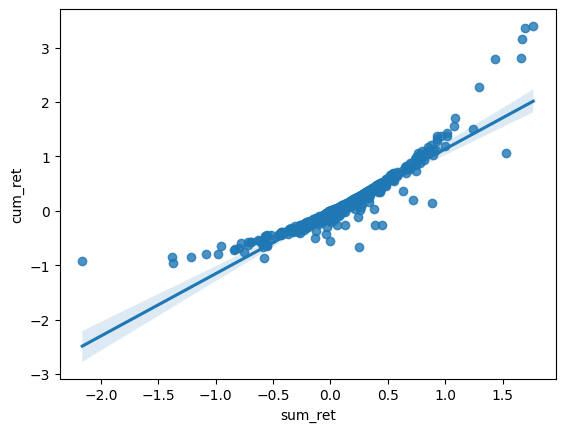

In [10]:
sns.regplot(data=merged_acct, y='cum_ret', x='sum_ret')

In [12]:
# https://totalrealreturns.com/n/F?start=2009-01-01&end=2009-12-31
_f = crsp.query('ticker=="F" and date.dt.year == 2009')
display(pd.concat([_f.head(1), _f.tail(1)]))
_f.ret.add(1).prod() - 1

,permno,ticker,shrcls,date,prc,vol,ret,bid,ask,shrout
57414,25785,F,A,2009-01-02,2.460,42108600,0.074,2.430,2.440,2318003
57665,25785,F,A,2009-12-31,10,31253700,0.001,9.990,10,3236249


np.float64(3.3668123863375614)

<Axes: xlabel='fyear', ylabel='cum_ret'>

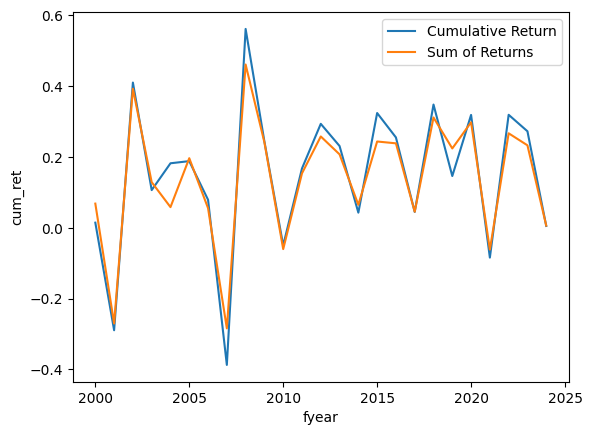

In [13]:
sns.lineplot(data=merged_acct, x='fyear', y='cum_ret', errorbar=None, label='Cumulative Return')
sns.lineplot(data=merged_acct, x='fyear', y='sum_ret', errorbar=None, label='Sum of Returns')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
_ = b.sort_values(S('permno date')).assign(
        retp1=lambda df: df.ret.add(1),
        totcum=lambda df: (df.groupby(S('permno')).retp1.cumprod() - 1),
        totsum=lambda df: df.groupby(S('permno')).ret.cumsum()
    ).merge(a[['permno', 'name']].drop_duplicates(), on='permno', how='left').sort_values(S('name date totcum')).groupby(S('name date')).tail(1)
_.head()

,permno,ticker,shrcls,date,prc,vol,ret,bid,ask,shrout,retp1,totcum,totsum,name
102218,61241,AMD,A,1999-01-04,28,2493800,-0.034,27.938,29,144775,0.966,-0.034,-0.034,ADVANCED MICRO DEVICES
102219,61241,AMD,A,1999-01-05,27.688,5231601,-0.011,27.688,27.938,144775,0.989,-0.045,-0.046,ADVANCED MICRO DEVICES
102220,61241,AMD,A,1999-01-06,27.250,6015601,-0.016,27,27.250,144775,0.984,-0.060,-0.061,ADVANCED MICRO DEVICES
102221,61241,AMD,A,1999-01-07,27.438,4853001,0.007,27.250,27.562,144775,1.007,-0.054,-0.055,ADVANCED MICRO DEVICES
102222,61241,AMD,A,1999-01-08,28,3477900,0.021,27.750,28,144775,1.021,-0.034,-0.034,ADVANCED MICRO DEVICES


In [244]:
_.groupby('name').totcum.max().sort_values()

name
AMERICAN AIRLINES GROUP INC      0.252
FORD MOTOR CO                    0.663
GENERAL MOTORS CO                1.487
BANK OF AMERICA CORP             1.832
CITIGROUP INC                    1.952
UNITED AIRLINES HOLDINGS INC     2.065
SHELL PLC                        2.204
DELTA AIR LINES INC              2.629
INTEL CORP                       2.692
COCA-COLA CO                     4.005
PROCTER & GAMBLE CO              6.718
EXXON MOBIL CORP                 6.915
CHEVRON CORP                     9.186
JPMORGAN CHASE & CO              9.506
WALMART INC                     10.330
ADVANCED MICRO DEVICES          13.067
TARGET CORP                     14.076
MICROSOFT CORP                  20.785
LULULEMON ATHLETICA INC         33.108
COSTCO WHOLESALE CORP           40.029
NIKE INC                        65.060
ALPHABET INC                    77.565
APPLE INC                      839.149
NVIDIA CORP                      3,956
Name: totcum, dtype: float64

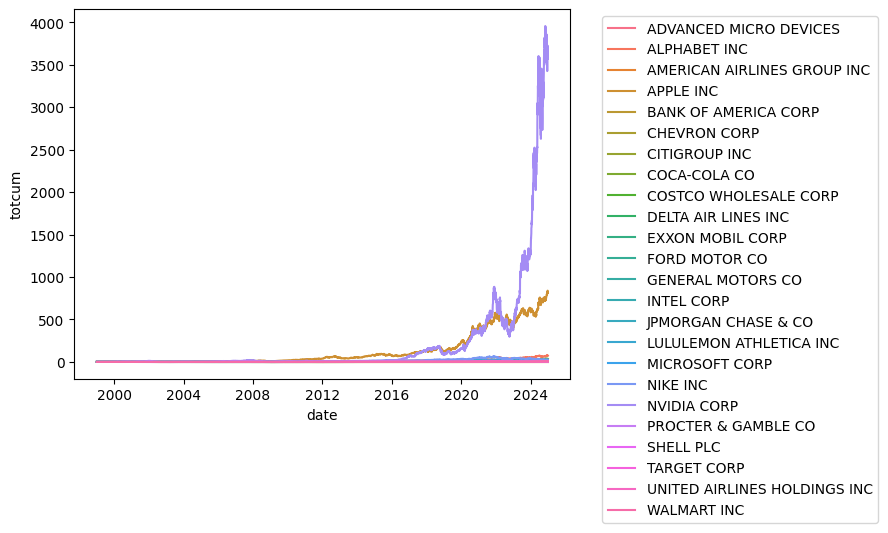

In [252]:
sns.lineplot(data=_, x='date', y='totcum', errorbar=None, hue='name')
# plt.ylim(0, 850)
# plt.ylim(0, 85)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

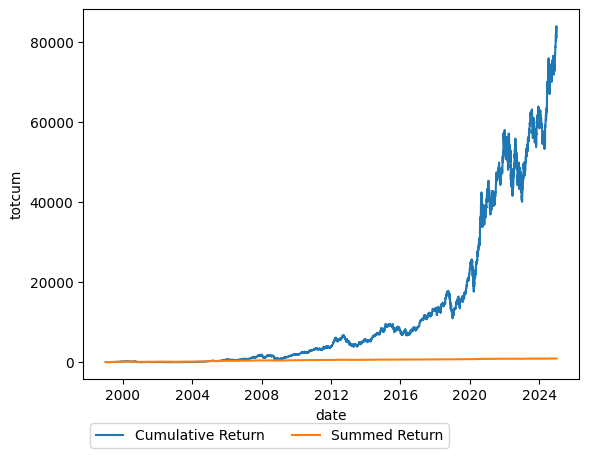

In [208]:
sns.lineplot(data=_, x='date', y='totcum', label='Cumulative Return', errorbar=None)
sns.lineplot(data=_, x='date', y='totsum', label='Summed Return', errorbar=None)
plt.legend(loc=2, bbox_to_anchor=(0, -0.1), ncols=2)

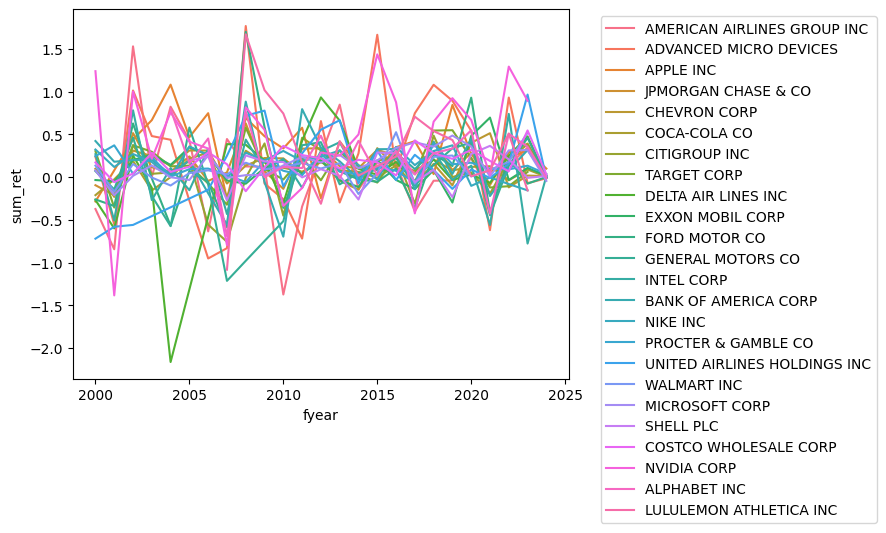

In [181]:
sns.lineplot(data=merged_acct, x='fyear', y='sum_ret', hue='name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Lab 5: Merging & Relational Databases 

Lab 5 introduces you to using SQL to query and filter data. You will work with stock data from CRSP (featuring in Project 2).

In [15]:
crsp1 = pd.read_csv('lab5_data_crsp.csv', parse_dates=['date']).query('date.dt.year >= 2020 and ticker.isin(["AAPL", "MSFT", "GOOGL"])')

Text(0.5, 0, 'Date')

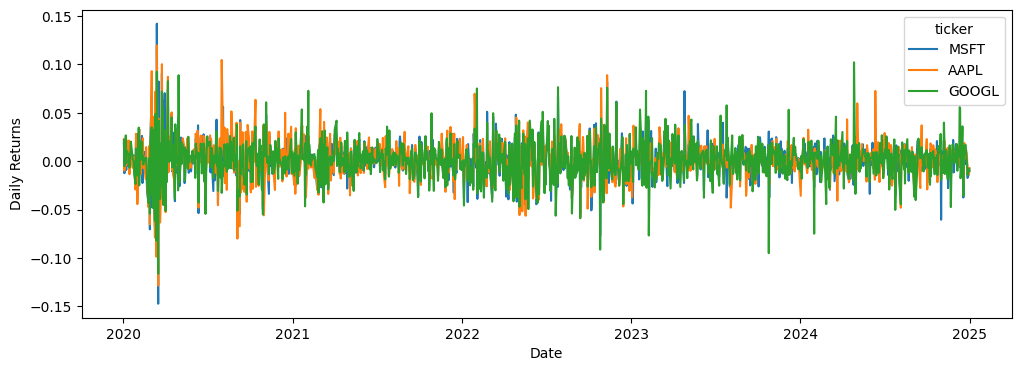

In [19]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=crsp1, x="date", y="ret", hue="ticker")
plt.ylabel("Daily Returns")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

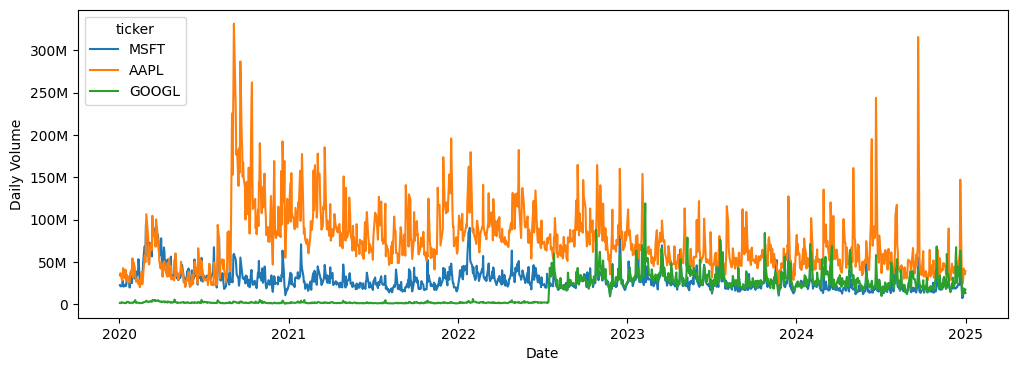

In [23]:
plt.figure(figsize=(12, 4))
ax = sns.lineplot(data=crsp1, x="date", y="vol", estimator="sum", hue="ticker")
ax.yaxis.set_major_formatter(mbt_ff(decimals=0, scale=1))
plt.ylabel("Daily Volume")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

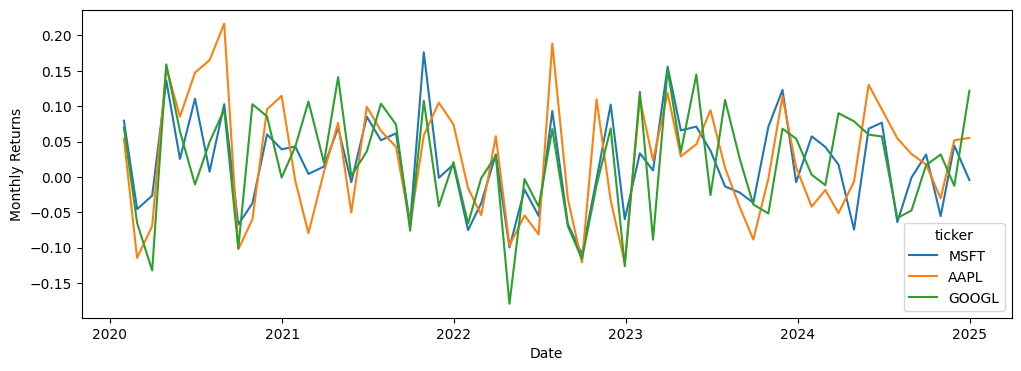

In [34]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=crsp1.assign(
        yearmo=lambda df: df.date.dt.to_period('M'),
        retp1=lambda df: df.ret.add(1),
        cumret=lambda df: (df.groupby(S('permno yearmo')).retp1.transform('prod') - 1)
    ).drop_duplicates(S('permno yearmo'), keep='last'),
    x="date", y="cumret", hue="ticker")
plt.ylabel("Monthly Returns")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

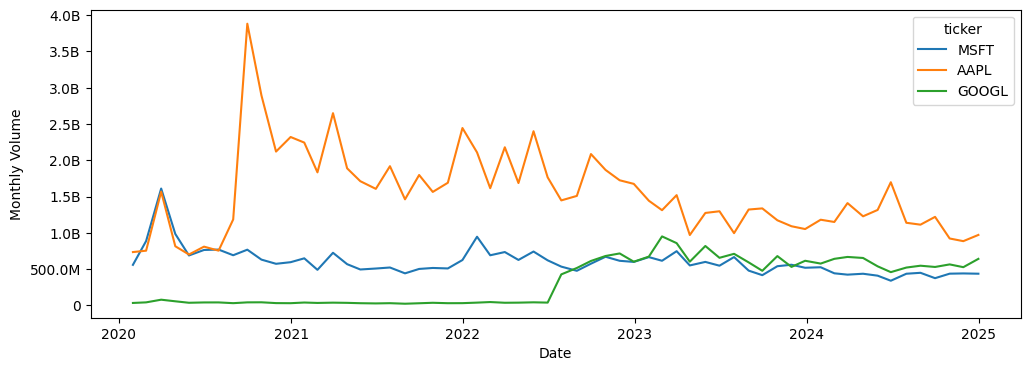

In [39]:
plt.figure(figsize=(12, 4))
ax = sns.lineplot(data=crsp1.assign(
        yearmo=lambda df: df.date.dt.to_period('M'),
        sumvol=lambda df: df.groupby(S('permno yearmo')).vol.transform('sum')
    ).drop_duplicates(S('permno yearmo'), keep='last'),
    x="date", y="sumvol", hue="ticker")
ax.yaxis.set_major_formatter(mbt_ff(decimals=1, scale=1))
plt.ylabel("Monthly Volume")
plt.xlabel("Date")

## Homework 5: Merging & Relational Databases 

In [41]:
goog = pd.read_csv('lab5_data_crsp.csv', parse_dates=['date']).query('date.dt.year >= 2020 and ticker.isin(["GOOG", "GOOGL"])')

In [42]:
all_data = pd.read_csv('lab5_data_crsp.csv', parse_dates=['date']).query('date.dt.year.between(2020, 2021)')

Text(0.5, 0, '')

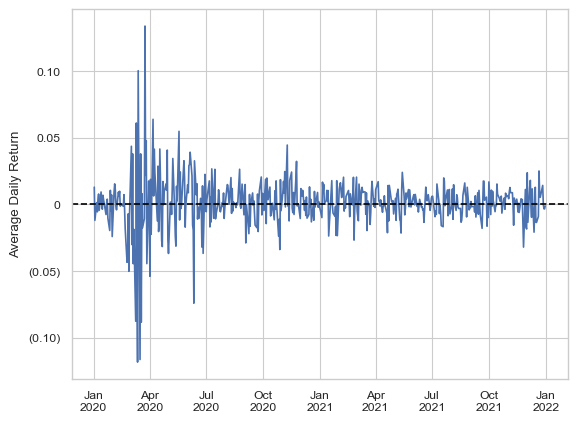

In [69]:
ax =sns.lineplot(data=all_data, x="date", y="ret", estimator="mean", errorbar=None)
ax.axhline(0, color="black", ls="--")
ax.yaxis.set_major_formatter(mbt_ff(decimals=2, scale=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.ylabel("Average Daily Return")
plt.xlabel(None)

Text(0.5, 0, '')

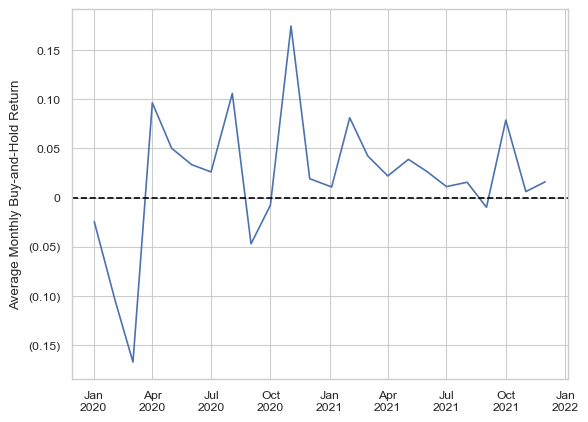

In [68]:
sns.set_theme(style="whitegrid", context="paper")
ax = sns.lineplot(data=all_data.assign(
        yearmo=lambda df: df.date.dt.to_period('M'),
        retp1=lambda df: df.ret.add(1),
        cumret=lambda df: (df.groupby(S('permno yearmo')).retp1.transform('prod') - 1)
    ).drop_duplicates(S('permno yearmo')),
    x="date", y="cumret", estimator="mean", errorbar=None)
ax.axhline(0, color="black", ls="--")
ax.yaxis.set_major_formatter(mbt_ff(decimals=2, scale=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
plt.ylabel("Average Monthly Buy-and-Hold Return")
plt.xlabel(None)

In [ ]:
sns.set_theme(style="whitegrid", context="paper")
ax = sns.lineplot(data=all_data.assign(
        yearmo=lambda df: df.date.dt.to_period('M'),
        retp1=lambda df: df.ret.add(1),
        cumret=lambda df: (df.groupby(S('permno yearmo')).retp1.transform('prod') - 1)
    ).drop_duplicates(S('permno yearmo')),
    x="date", y="cumret", estimator="mean", errorbar=None)
ax.axhline(0, color="black", ls="--")
ax.yaxis.set_major_formatter(mbt_ff(decimals=2, scale=1))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
plt.ylabel("Average Monthly Buy-and-Hold Return")
plt.xlabel(None)

# Example SQL

In [ ]:
sql = """
WITH
event_window_numbered AS (
    SELECT
        firm_id, c.ticker, c.shrcls, fyear, earn_annc_date, date, ret, prc * shrout AS mcap,
        ROW_NUMBER() OVER(PARTITION BY firm_id, c.ticker, c.shrcls, fyear ORDER BY d.date) AS trade_date_num
    FROM compustat_annual AS c
    INNER JOIN crsp_daily AS d
        ON c.ticker = d.ticker
        AND c.shrcls = d.shrcls
        AND d.date > c.earn_annc_date_prev
        AND d.date < c.earn_annc_date_next
    ORDER BY firm_id, c.ticker, c.shrcls, fyear, date
),
event_data_with_relative_day AS (
    SELECT
        firm_id, fyear, ticker, shrcls, date, ret, mcap,
        (trade_date_num - MIN(CASE WHEN date >= earn_annc_date THEN trade_date_num END) OVER (PARTITION BY firm_id, ticker, shrcls, fyear)) AS relative_trade_day
    FROM event_window_numbered
),
bhret_yr_prev AS (
    SELECT
        firm_id, ticker, shrcls, fyear, EXP(SUM(LN(1 + ret))) - 1 AS bhret_year_prev
    FROM event_data_with_relative_day
    WHERE relative_trade_day < 0
    GROUP BY firm_id, ticker, shrcls, fyear
    HAVING COUNT(ret) > 130
),
bhret_yr_next AS (
    SELECT
        firm_id, ticker, shrcls, fyear, EXP(SUM(LN(1 + ret))) - 1 AS bhret_year_next
    FROM event_data_with_relative_day
    WHERE relative_trade_day > 0
    GROUP BY firm_id, ticker, shrcls, fyear
    HAVING COUNT(ret) > 130
),
bhret_m1p1 AS (
    SELECT
        firm_id, ticker, shrcls, fyear, EXP(SUM(LN(1 + ret))) - 1 AS bhret_m1_p1
    FROM event_data_with_relative_day
    WHERE relative_trade_day BETWEEN -1 AND 1
    GROUP BY firm_id, ticker, shrcls, fyear
    HAVING COUNT(ret) = 3
),
bhret_0 AS (
    SELECT
        firm_id, ticker, shrcls, fyear, ret AS bhret_0, mcap AS mcap_0
    FROM event_data_with_relative_day
    WHERE relative_trade_day = 0
)

SELECT
    c.*,
    m4.ticker,
    m1.bhret_year_prev,
    m2.bhret_year_next,
    m3.bhret_m1_p1,
    m4.bhret_0,
    m4.mcap_0
FROM compustat_annual AS c
LEFT JOIN bhret_yr_prev AS m1
    ON c.firm_id = m1.firm_id
    AND c.ticker = m1.ticker
    AND c.shrcls = m1.shrcls
    AND c.fyear = m1.fyear
LEFT JOIN bhret_yr_next AS m2
    ON c.firm_id = m2.firm_id
    AND c.ticker = m2.ticker
    AND c.shrcls = m2.shrcls
    AND c.fyear = m2.fyear
LEFT JOIN bhret_m1p1 AS m3
    ON c.firm_id = m3.firm_id
    AND c.ticker = m3.ticker
    AND c.shrcls = m3.shrcls
    AND c.fyear = m3.fyear
LEFT JOIN bhret_0 AS m4
    ON c.firm_id = m4.firm_id
    AND c.ticker = m4.ticker
    AND c.shrcls = m4.shrcls
    AND c.fyear = m4.fyear
ORDER BY c.firm_id, c.fyear
"""
dfc = (
    read_sql(sql)
    .assign(
        _weight=lambda df: (df.mcap_0 / df.groupby('firm_id fyear'.split()).mcap_0.transform('sum')).fillna(1),
        bhret_year_prev_wt=lambda df: df.bhret_year_prev * df._weight,
        bhret_year_next_wt=lambda df: df.bhret_year_next * df._weight,
        bhret_m1_p1_wt=lambda df: df.bhret_m1_p1 * df._weight,
        bhret_year_prev=lambda df: df.groupby('firm_id fyear'.split()).bhret_year_prev_wt.transform('sum', min_count=1),
        bhret_year_next=lambda df: df.groupby('firm_id fyear'.split()).bhret_year_next_wt.transform('sum', min_count=1),
        bhret_m1_p1=lambda df: df.groupby('firm_id fyear'.split()).bhret_m1_p1_wt.transform('sum', min_count=1),
    )
    .sort_values(['firm_id', 'fyear', '_weight'])
    .drop_duplicates('firm_id fyear'.split(), keep='last')
    .drop(columns=['_weight', 'bhret_year_prev_wt', 'bhret_year_next_wt', 'bhret_m1_p1_wt', 'mcap_0'])
)
# dfc.head()
dfc.describe()